In [1]:
import wave
import struct

In [2]:
def detect_encoding(file_path):
    encoding = "utf-8"
    try:
        l = open(file_path, 'r', encoding="utf-8").read()
        if l.startswith("\ufeff"):
            encoding = "utf-8-sig"
    except UnicodeDecodeError:
        try:
            open(file_path, 'r', encoding="utf-16").read()
            encoding = "utf-16"
        except UnicodeError:
            encoding = "cp1251"
    return encoding

In [3]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]

level2code = {i: j for i, j in zip(levels, level_codes)}
code2level = {j: i for i, j in zip(levels, level_codes)}

sampwidth_to_char = {1: "c", 2: "h", 4: "i"}

In [4]:
class Params:
  def __init__(self, s_rate, s_width, n_channels) -> None:
      self.samplerate = s_rate
      self.sampwidth = s_width
      self.numchannels = n_channels

In [5]:
class Label:
  def __init__(self, position, level, text) -> None:
    self.position = position
    self.level = level
    self.text = text

In [6]:
class Seg:
  def __init__(self, filename: str = None, labels: list = [], params: Params = Params(22050, 2, 1)):
    self.filename = filename
    self.labels = labels
    self.params = params

  def read_seg_file(self):
    try:
      with open(self.filename, "r", encoding=detect_encoding(self.filename)) as f:
        lines = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
      print(self.filename, " не найден")

    self.init_params()

    try:
      index_labels = lines.index('[LABELS]')
    except ValueError:
      print("Seg-файл не содержит секции LABELS")

    labels_ = lines[index_labels + 1 :]
    labels_arr = [Label(
        int(line.split(",")[0]) // self.params.sampwidth // self.params.numchannels,
        code2level[int(line.split(",")[1])],
        line.split(",")[2]
    ) for line in labels_ if line.count(",") >= 2]

    self.labels = labels_arr

  def init_params(self):
    try:
      with open(self.filename, "r", encoding=detect_encoding(self.filename)) as f:
        lines = [line.strip() for line in f.readlines()]
    except FileNotFoundError:
      print(self.filename, " не найден")

    try:
      index_params = lines.index('[PARAMETERS]')
    except ValueError:
      print("Seg-файл не содержит секции PARAMETERS")

    try:
      index_labels = lines.index('[LABELS]')
    except ValueError:
      print("Seg-файл не содержит секции LABELS")

    parameters = lines[index_params + 1 : index_labels]

    param_dict = {str(line.split("=")[0]): int(line.split("=")[1]) for line in parameters}

    self.params = Params(param_dict["SAMPLING_FREQ"], param_dict["BYTE_PER_SAMPLE"], param_dict["N_CHANNEL"])

  def write_seg_file(self):
    params = {
        "SAMPLING_FREQ": self.params.samplerate,
        "BYTE_PER_SAMPLE": self.params.sampwidth,
        "CODE": 0,
        "N_CHANNEL": self.params.numchannels,
        "N_LABEL": len(self.labels)
    }
    with open(self.filename, "w", encoding="utf-8") as f:
      f.write("[PARAMETERS]\n")
      for key in params.keys():
        f.write(key + '=' + str(params[key]) + "\n")
      f.write("[LABELS]\n")
      for label in self.labels:
        pos = label.position * self.params.numchannels * self.params.sampwidth
        f.write(f"{pos}, {level2code[label.level]}, {label.text}\n")
    print("Параметры и метки записаны в файл ", self.filename)

    def get_labels_in_pairs(self, num_samples):
      ends = [end.position for start, end in zip(self.labels, self.labels[1:])]
      ends.append(num_samples)
      return [(label.position, ends[i], label.text) for i, label in enumerate(self.labels)]

In [7]:
class Signal:
  def __init__(self, filename: str, signal: list = [], params: Params = None, seg: Seg = None):
    self.signal: list = signal
    self.filename: str = filename
    self.seg: Seg = seg
    self.params: Params = params

  def init_params(self):
    if self.params is not None:
      return
    if self.seg is not None:
      self.seg.init_params()
      self.params = self.seg.params
    else:
      default_params = Params(22050, 2, 1)
      self.params = default_params

  def read_wav(self):
    try:
      f = wave.open(self.filename)
    except FileNotFoundError:
      print(self.filename, " не найден")

    num_samples = f.getnframes()
    samplerate = f.getframerate()
    sampwidth = f.getsampwidth()
    num_channels = f.getnchannels()

    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples * num_channels) + sampwidth_to_char[sampwidth]

    signal = struct.unpack(fmt, f.readframes(num_samples * num_channels))
    self.signal = signal
    new_params = Params(samplerate, sampwidth, num_channels)
    self.params = new_params

  def read_sbl(self):
    with open(self.filename, "rb") as f:
      raw_signal = f.read()
    num_samples = len(raw_signal) // self.params.sampwidth
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]
    signal = struct.unpack(fmt, raw_signal)
    self.signal = signal

  def read_sound_file(self):
    self.init_params()
    if self.filename.endswith(".wav"):
        self.read_wav()
    elif self.filename.endswith(".sbl"):
        self.read_sbl()
    else:
        raise ValueError("Неизвестное расширение, ", self.filename)

  def write_wav_file(self):
    num_samples = self.params.samplerate * 2
    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]

    signal_ = struct.pack(fmt, *self.signal)

    f = wave.open(self.filename, "wb")
    f.setnchannels(self.params.numchannels)
    f.setsampwidth(self.params.sampwidth)
    f.setframerate(self.params.samplerate)
    f.writeframes(signal_)
    f.close()

In [8]:
!wget https://phonetics-spbu.github.io/courses/ling_programming/files/cta0001.wav

--2025-12-04 11:30:12--  https://phonetics-spbu.github.io/courses/ling_programming/files/cta0001.wav
Resolving phonetics-spbu.github.io (phonetics-spbu.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to phonetics-spbu.github.io (phonetics-spbu.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77114 (75K) [audio/wav]
Saving to: ‘cta0001.wav’

cta0001.wav         100%[===================>]  75.31K  --.-KB/s    in 0.005s  

2025-12-04 11:30:12 (15.9 MB/s) - ‘cta0001.wav’ saved [77114/77114]



In [9]:
filename = r"cta0001.wav"
wav_signal = Signal(filename)
wav_signal.read_wav()

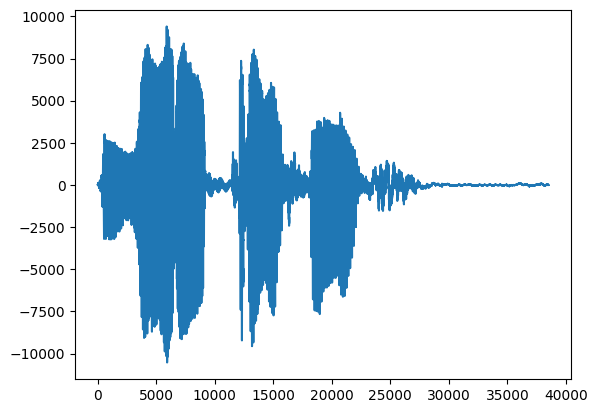

In [10]:
import matplotlib.pyplot as plt
plt.plot(wav_signal.signal)
plt.show()

In [30]:
from scipy import signal
from scipy.fft import rfft, rfftfreq
import numpy as np

def print_sonogram(filename, N_wind, window_type):
  """
  Функция принимает на вход имя аудиофайла, размер окна и тип оконной функции. Печатает сонограмму сигнала.
    1. Считываем сигнал, определяем длительность
    2. дополняем сигнал нулями
    3. находим число окон
    4. разбиваем сигнал на окна, делаем Фурье с оконной ф-ей
    5. печатаем сонограмму
  """
  wav = Signal(filename)
  wav.read_wav()

  wav_signal = list(wav.signal)

  sig_len = len(wav_signal)
  res = int(sig_len % (N_wind // 2))
  num_zeros = N_wind // 2 - res
  wav_signal.extend(np.zeros(num_zeros))

  num_of_windows = (len(wav_signal) - N_wind) // (N_wind // 2)

  sonogram_list = []

  for i in range(num_of_windows):
    sig_part = wav_signal[i * N_wind // 2 : i * N_wind // 2 + N_wind]
    sig_part_windowed = sig_part * signal.get_window(window_type, N_wind)
    spectrum = rfft(sig_part_windowed)
    sonogram_list.append([np.abs(x**2) for x in spectrum])

  heatmap = np.transpose(sonogram_list)

  plt.imshow(heatmap, norm="log", origin="lower")

  x_marks_number = len(heatmap[0])


[[6.51586313e+06 1.33587977e+06 1.18537797e+08 ... 3.72583284e+06
  2.02465662e+06 4.48942788e+06]
 [3.27780491e+07 2.23115529e+08 1.86219213e+09 ... 4.69757008e+06
  2.49411119e+06 1.72303175e+06]
 [9.87790557e+07 5.16599421e+08 4.59240651e+09 ... 6.29420328e+05
  2.54395165e+05 8.50882866e+04]
 ...
 [1.17472746e+03 7.82835109e+02 2.87426956e+03 ... 2.55673384e+02
  7.96393156e+01 7.32385142e+01]
 [6.42964034e+02 8.81970713e+02 1.20313653e+03 ... 1.51154664e+02
  5.86234052e+01 4.52111875e+01]
 [1.09836872e+03 6.30017881e+02 1.11258847e+02 ... 8.11980260e+01
  8.56049592e+01 6.19010221e-01]]


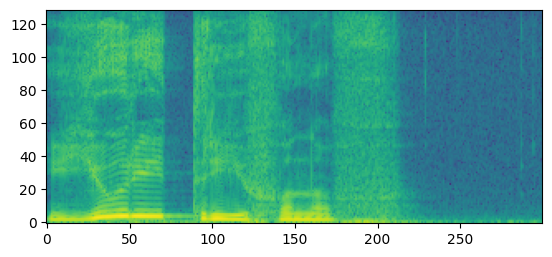

In [31]:
print_sonogram(filename, 256, "hann")